In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import datetime
from collections import defaultdict

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk import ngrams

# Gensim
import gensim
from gensim import models
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import Phrases

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt 

from scipy.stats import pearsonr

import statsmodels
from statsmodels.tsa.stattools import grangercausalitytests

/home/jagaskak/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
'''
This cell contains the processing of NYTimes data and IEM stock market data. You should only run this once.
'''

stop_words = stopwords.words('english')
stop_words.extend(['mr', 'ms', 'mrs', 'said'])

# Tokenize and remove stop words from content
def tokenize(content, lemmatize=False):
    words = gensim.utils.simple_preprocess(content, deacc=True)  # tokenizes
    return words

def remove_stopwords(content):
    words = []
    for word in content:
        if word in stop_words:
            continue
        words.append(word)
    return words


'''
Retrieve Data from files
'''

# New York Times Data
rows = []
dates = []
articles = []
for month in range(5, 11):
    with open("Data/NYTimes/"+ str(month) + ".txt") as f:
        for i, line in enumerate(f):
            date, article = line.split(",", 1)
            timestamp = datetime.datetime.strptime(date, "%Y-%m-%dT%H:%M:%S%z").date()
            tokenized = tokenize(article)
            destopped = remove_stopwords(tokenized)

            articles.append(destopped)
            dates.append(timestamp)
            rows.append([timestamp, destopped])

nytimes = pd.DataFrame(rows, columns=["Date", "Content"]) 
unique_dates = sorted(list(set(nytimes["Date"])))
# print (unique_dates)

# Time Series Data
ts_months = ["May", "Jun", "Jul", "Aug", "Sep", "Oct"]
cols = ['Date', 'LastPrice']
stock_prices = pd.DataFrame()
for month in ts_months:
    ts_df = pd.read_csv("Data/PriceHistory/" + month + ".txt", delim_whitespace=True)
    ts_df['Date'] =  ts_df['Date'].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%y").date())
    
    Gore = ts_df.loc[ts_df['Contract'] == 'Dem'][['Date', 'LastPrice']].fillna(0).reset_index()
    Bush = ts_df.loc[ts_df['Contract'] == 'Rep'][['Date', 'LastPrice']].fillna(0).reset_index()

    # Gore/(Gore + Bush)
    relation = list(zip(Gore['Date'], (Gore['LastPrice']/(Gore['LastPrice'] + Bush['LastPrice'])).fillna(0.001)))
    stock_prices = stock_prices.append(relation, ignore_index=True)

stock_prices.columns = cols


'''
BOW - corpus, date x word cnts
'''
# Create Dictionary
id2word = corpora.Dictionary(articles)

# Filtering: 
# Keep words that appear in at least 1% of docs --> approximately 50 topics
# Don't keep words that appear in more that 70% of docs in corpus
# id2word.filter_extremes(no_below=50, no_above=0.7)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in articles]

# TF-IDF seems to give better coherence (but it wasn't in the paper...)
tfidf = models.TfidfModel(corpus)
tfidf_corpus = tfidf[corpus]

# Human readable format of corpus (term-frequency)
# [[(id2word[id], freq) for id, freq in cp] for cp in tfidf_corpus[:1]][0][:5]

# bow by date
date_term_cnts = defaultdict(lambda: [])

for index, row in nytimes.iterrows():
    date = row["Date"]
    content = row["Content"]
    
    date_term_cnts[date] += content
    
date_term_cnts = list(date_term_cnts.items())
date_term_cnts = [(date, {id2word[id]: freq for id, freq in id2word.doc2bow(text)}) for date, text in date_term_cnts]
date_term_cnts = sorted(date_term_cnts, key=lambda x: x[0])
date_term_cnts = pd.DataFrame([date_term_cnts[i][1] for i in range(len(date_term_cnts))], index=[date_term_cnts[i][0] for i in range(len(date_term_cnts))]).fillna(0.0)


/home/jagaskak/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
'''
This cell contains function definitions.
'''

def rel_purity(currPurity, prevPurity):
    return abs(currPurity - prevPurity)/prevPurity


# Select the model and print the topics
def get_topics(lda_model, num_topics=-1, num_words=100, prob_thresh=0.8):
    topics = []
    for topic, topic_words in lda_model.print_topics(num_topics=num_topics, num_words=num_words):
        words = topic_words.split(" + ")
        all_words = []
        all_prob = 0
        for elem in words:
            prob, word = elem.split("*")
            all_prob += float(prob)
            all_words.append(word.split('"')[1])

            if all_prob >= prob_thresh:
                break
        topics.append((topic, all_words))
    
    return topics


'''
Significant portion of grangers_causality_matrix function was taken from stackoverflow post:
https://stackoverflow.com/questions/58005681/is-it-possible-to-run-a-vector-autoregression-analysis-on-a-large-gdp-data-with
'''
def grangers_causality_matrix(data, variables, maxlag=5, test='ssr_ftest', verbose=False):
    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    lags    = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    
    for c in dataset.columns:
        for r in dataset.index:            
            test_result = grangercausalitytests(data[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1], 4) for i in range(maxlag)]
            
            if verbose: 
                print(f'Y = {r}, X = {c}, P Values = {p_values}')

            # smaller p-val corresponds to higher f-val
            min_p_value_i = np.argmin(p_values)
            min_p_value = p_values[min_p_value_i]
            dataset.loc[r, c] = min_p_value
            
            lags.loc[r, c] = min_p_value_i
   
    return dataset, lags

def get_causal_vars(data, significance=0.95, getLags=False, getCausalSig=False, verbose=False):
    cols = data.columns[:-1]
    causal_vars = []
    causal_lags = []
    
    for col in cols:
        try:
            gc, lags = grangers_causality_matrix(data[[col, 'LastPrice']], 
                                             variables=[col, 'LastPrice'], 
                                             verbose=False)
        except:
            raise Exception(data[[col, 'LastPrice']])
        
        gc = 1 - gc
        
        col_causes = gc.loc['LastPrice', col] >= significance
        col_causedBy = gc.loc[col, 'LastPrice'] >= significance
        if col_causes or col_causedBy:
            if getCausalSig:
                causal_vars.append((col, max(gc.loc['LastPrice', col], gc.loc[col, 'LastPrice'])))
            else:
                causal_vars.append(col)
            
            if getLags:
                # if granger causality for topic causing ts and ts causing topic both significant, choose higher sig
                if col_causes and col_causedBy:
                    if gc.loc['LastPrice', col] >= gc.loc[col, 'LastPrice']:
                        causal_lags.append(lags.loc['LastPrice', col])
                    else:
                        causal_lags.append(lags.loc[col, 'LastPrice'] * -1)
                elif col_causes:
                    causal_lags.append(lags.loc['LastPrice', col])
                else:
                    causal_lags.append(lags.loc[col, 'LastPrice'] * -1)
    if getLags:
        return causal_vars, causal_lags
    
    return causal_vars
                
def get_word_stream(nytimes, topics, causal_topics):
    ct_ws = []
    for ct in causal_topics:
        causal_vocab = list(set(topics[ct][1]))
        date_terms = pd.DataFrame(np.zeros((len(unique_dates), len(causal_vocab))), index=unique_dates, columns=causal_vocab)
        
        for word in causal_vocab:
            date_terms[word] = date_term_cnts[word]
            
        ct_ws.append((ct, date_terms))
    
    return ct_ws

def get_impact_words(topic_wordstream, significance=0.95, verbose=False):
    topic_impact_words = []
    
    for topic, ws in topic_wordstream:
        ws_prices = ws.join(stock_prices.set_index('Date')).dropna()        
        ws_gc = get_causal_vars(ws_prices, significance=significance, getCausalSig=True, verbose=verbose)
        
        pos = []
        neg = []
        for word, sig in ws_gc:                
            corr = pearsonr(ws_prices[word], stock_prices['LastPrice'])[0]
            if corr >= 0:
                pos.append((word, sig))
            else:
                neg.append((word, sig))
                
        topic_impact_words.append((topic, pos, neg))
    
    return topic_impact_words
        
def construct_prior(impact_words, curr_k, const_k_increase=0, sig=0.95, alter_k=True):
    # find number of topics that we are splitting
    if alter_k:
        new_k = curr_k + len(impact_words) + const_k_increase
    else:
        new_k = curr_k
    word_priors = np.zeros((new_k, date_term_cnts.shape[1])) + (1/len(id2word))

    i = 0
    for topic_num, pos, neg in impact_words:
        pos_denom = sum([granger-sig for word, granger in pos])
        neg_denom = sum([granger-sig for word, granger in neg])
        
        if len(pos) < 0.1 * len(neg):
            # num neg words >> num pos
            for word, granger in pos:              
                word_priors[i, id2word.token2id[word]] = 0
            for word, granger in neg:
                word_priors[i, id2word.token2id[word]] = (granger-sig)/neg_denom 
            i += 1
            continue
            
        elif len(neg) < 0.1 * len(pos):
            # num pos words >> num neg
            for word, granger in pos:              
                word_priors[i, id2word.token2id[word]] = (granger-sig)/pos_denom 
            for word, granger in neg:
                word_priors[i, id2word.token2id[word]] = 0
            i += 1
            continue
            
        for word, granger in pos:              
            word_priors[i, id2word.token2id[word]] = (granger-sig)/pos_denom 
        
        for word, granger in neg:
            word_priors[i + 1, id2word.token2id[word]] = (granger-sig)/neg_denom 
        
        i += 2
    
    return word_priors
            
def calculate_purity(pWords, nWords):
    n = float(len(pWords) + len(nWords))
    if n == 0:
        return 0
    pProb = len(pWords)/n
    nProb = len(nWords)/n
    
    pProb = pProb if pProb else 1
    nProb = nProb if nProb else 1
    
    entropy = pProb * np.log(pProb) + nProb * np.log(nProb)
    purity = 100 + 100 * entropy
    return purity

def calculate_conf(impact_words):
    all_conf = 0.0
    num_words = 0
    for topic, pos, neg in impact_words:
        num_words += len(pos) + len(neg)
        for words, gc in pos:
            all_conf += gc

        for words, gc in neg:
            all_conf += gc

    return all_conf/num_words*100 if num_words else 0


def show_plot(x, yData, xaxislabel, yaxislabel, labels, xticks=None, yaxisrange=None, title=None, legend_title=None, marker=".", saveAs=None):
    if len(yData) != len(labels):
        raise ValueError("Number of labels should equal number of lines you want to plot")
    
    plt.xlabel(xaxislabel)
    plt.ylabel(yaxislabel)
    plt.grid()
        
    for i in range(len(yData)):
        plt.plot(x, yData[i], label=labels[i], marker=marker)
    plt.legend(loc=2, bbox_to_anchor=(1.05, 1), title=legend_title)
    
    if yaxisrange:
        plt.ylim(yaxisrange)
    if xticks:
        plt.xticks(xticks)
    if title:
        plt.title(title)
    
    if saveAs:
        plt.savefig(saveAs, bbox_inches='tight')
    plt.show()

/home/jagaskak/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
'''
This function will run topic modeling with time series feedback 

Parameters:
paramCtrl  -- str (either 'k' or 'decay'), tells function to test various k or decay values
params     -- list of integers, each val in list is either a k or decay values to test.
              For k values, the last k value will be used to test a variable number of topics starting at k topics.
              In every iteration of ITMTF, k will increase by the number of causal topics found + some constant
decay      -- (0.5, 1] decay parameter to use when running lda (effective only when paramCtrl='k')
k          -- Interger representing number of topics to use when running lda (effective only when paramCtrl='decay')
iterations       -- Integer number of iterations to run ITMTF
const_k_increase -- Integer number of topics to increase (in addition to number of causal topics found) 
                    each iteration when running varying number of topics (effective only when paramCtrl='k')
                    Default is 0
verbose          -- True/False Print out purity and confidence every iteration

Returns:
k_lda_model    -- The final lda_model  
k_avg_purities -- Average purity of all causal topics in each iteration
k_avg_conf     -- Average confidence of all causal topics in each iteration
'''
def ITMTF(paramCtrl, params, decay=1, k=30, const_k_increase=5, iterations=5, verbose=True):
    thirdLDAModel = None
    
    prevPurity = 100
    purity = 0
    alpha = "auto"
    eta = "auto"
    alter_k = False

    all_avg_purities = []
    all_avg_conf = []

    for val in params:
        if paramCtrl == "k":
            k = val
        elif paramCtrl == "decay":
            decay = val
        else:
            raise ValueError("Invalid argument. Please read docs to understand use case")
        
        if verbose:
            print ("\n\nk: ", k)
            print ("decay: ", decay)

        avg_purities = []
        avg_confidences = []

        num_iter = 0
        while num_iter < iterations:

            if verbose and alter_k == "k":
                print ("\nNumber topics: ", k)          

            lda_model = gensim.models.ldamodel.LdaModel(
                                    corpus=tfidf_corpus,
                                    id2word=id2word,
                                    num_topics=k, 
                                    alpha=alpha,
                                    eta=eta,
                                    decay=decay)

            topics = get_topics(lda_model, prob_thresh=0.3, num_words=50)
            document_topics = lda_model.get_document_topics(corpus)
            date_doc_topics = list(zip(nytimes["Date"], lda_model.get_document_topics(corpus)))

            # for any given day, you look at all the diff topics and identify the prob of that topic
            date_topic_prob = np.zeros((len(unique_dates), k))
            for date, article in date_doc_topics:
                i = unique_dates.index(date)
                for topic, prob in article:
                    date_topic_prob[i][topic] += prob 

            date_topic = pd.DataFrame(date_topic_prob, index=unique_dates)
            date_topic["Date"] = unique_dates

            date_topic_prices = date_topic.set_index('Date').join(stock_prices.set_index('Date')).dropna()
            causal_topics = get_causal_vars(date_topic_prices)
            ct_ws = get_word_stream(nytimes, topics, causal_topics)

            impact_words = get_impact_words(ct_ws)

            # Calculate Purity
            purities = [calculate_purity(topic[1], topic[2]) for topic in impact_words]
            if len(purities) == 0:
                # Try again, we got no causal topics
                continue

            avg_purity = sum(purities)/len(purities)
            prevPurity = purity
            purity = avg_purity

            avg_purities.append(purity)

            # Calculate Confidence
            avg_conf = calculate_conf(impact_words)
            avg_confidences.append(avg_conf)
            
            if verbose:
                print ("Purity: ", purity)  
                print ("Avg. Conf: ", avg_conf)

            # Prior for next iteration
            eta = construct_prior(impact_words, k, const_k_increase=const_k_increase, alter_k=alter_k)

            # adjust num topics
            if alter_k:
                k += len(impact_words) + const_k_increase

    #         if keep3rd and (i + 1) == 3:
    #             thirdLDAModel = lda_model
            num_iter += 1

        all_avg_purities.append(avg_purities)
        all_avg_conf.append(avg_confidences)

        # reset params
        eta = "auto"

        if paramCtrl == "k":
            alter_k = (k == params[-2])

    return lda_model, all_avg_purities, all_avg_conf

k_lda_model, k_avg_purities, k_avg_conf = ITMTF("k", params=[10, 20, 30, 40, 10], const_k_increase=3)
# mu_lda_model, mu_avg_purities, mu_avg_conf = ITMTF("decay", params=[0.51, 0.6, 0.7, 0.8, 0.9, 1])

/home/jagaskak/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)




k:  10
decay:  1
Purity:  58.9883681711591
Avg. Conf:  96.92714285714287


/home/jagaskak/.local/lib/python3.8/site-packages/gensim/models/ldamodel.py:824: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


Purity:  78.48306182113217
Avg. Conf:  97.0995238095238


/home/jagaskak/.local/lib/python3.8/site-packages/gensim/models/ldamodel.py:824: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


Purity:  43.76648553811917
Avg. Conf:  98.04874999999998


/home/jagaskak/.local/lib/python3.8/site-packages/gensim/models/ldamodel.py:824: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


Purity:  81.25549517937306
Avg. Conf:  96.72416666666666


/home/jagaskak/.local/lib/python3.8/site-packages/gensim/models/ldamodel.py:824: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


Purity:  73.51469004711728
Avg. Conf:  97.39166666666668


k:  20
decay:  1
Purity:  32.710980422286106
Avg. Conf:  97.37478260869564


/home/jagaskak/.local/lib/python3.8/site-packages/gensim/models/ldamodel.py:824: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


Purity:  48.383858182028334
Avg. Conf:  97.49142857142859


/home/jagaskak/.local/lib/python3.8/site-packages/gensim/models/ldamodel.py:824: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


Purity:  49.95975764618122
Avg. Conf:  96.73200000000001


/home/jagaskak/.local/lib/python3.8/site-packages/gensim/models/ldamodel.py:824: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


Purity:  49.48418133659994
Avg. Conf:  97.54333333333331


/home/jagaskak/.local/lib/python3.8/site-packages/gensim/models/ldamodel.py:824: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


Purity:  46.30631764884349
Avg. Conf:  97.28861111111115


k:  30
decay:  1
Purity:  46.757516826014395
Avg. Conf:  97.30097560975611


/home/jagaskak/.local/lib/python3.8/site-packages/gensim/models/ldamodel.py:824: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


Purity:  43.071158279757746
Avg. Conf:  97.53121212121212


/home/jagaskak/.local/lib/python3.8/site-packages/gensim/models/ldamodel.py:824: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


Purity:  34.4608160950143
Avg. Conf:  97.72217391304348


/home/jagaskak/.local/lib/python3.8/site-packages/gensim/models/ldamodel.py:824: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


Purity:  50.62893401958432
Avg. Conf:  97.41282608695651


/home/jagaskak/.local/lib/python3.8/site-packages/gensim/models/ldamodel.py:824: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


Purity:  60.98002337648507
Avg. Conf:  97.5817857142857


k:  40
decay:  1
Purity:  42.29412638372314
Avg. Conf:  97.70139784946234


/home/jagaskak/.local/lib/python3.8/site-packages/gensim/models/ldamodel.py:824: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


Purity:  51.96650630295282
Avg. Conf:  97.6214473684211


/home/jagaskak/.local/lib/python3.8/site-packages/gensim/models/ldamodel.py:824: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


Purity:  44.07350031049184
Avg. Conf:  97.55333333333334


/home/jagaskak/.local/lib/python3.8/site-packages/gensim/models/ldamodel.py:824: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


Purity:  45.1016940791358
Avg. Conf:  97.78381818181818


/home/jagaskak/.local/lib/python3.8/site-packages/gensim/models/ldamodel.py:824: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


Purity:  55.392810945095285
Avg. Conf:  97.41469696969695


k:  10
decay:  1
Purity:  36.34858317051872
Avg. Conf:  97.68666666666668


/home/jagaskak/.local/lib/python3.8/site-packages/gensim/models/ldamodel.py:824: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


Purity:  54.33767729007349
Avg. Conf:  97.82875


/home/jagaskak/.local/lib/python3.8/site-packages/gensim/models/ldamodel.py:824: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


Purity:  53.7587382502967
Avg. Conf:  97.58218749999999


/home/jagaskak/.local/lib/python3.8/site-packages/gensim/models/ldamodel.py:824: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


Purity:  42.57575500997741
Avg. Conf:  97.85803921568628


/home/jagaskak/.local/lib/python3.8/site-packages/gensim/models/ldamodel.py:824: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


Purity:  43.51576457292854
Avg. Conf:  97.72049180327868


/home/jagaskak/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


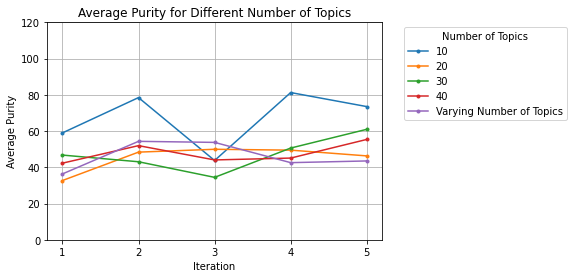

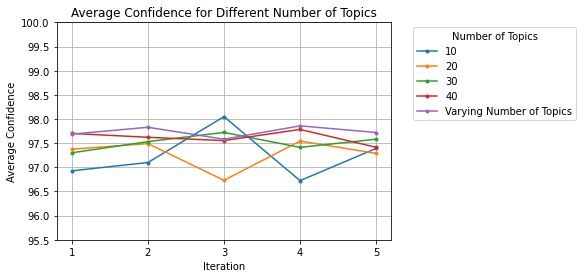

In [37]:
'''
Plotting purity and confidence for different number of topics
'''

k_labels = ["10", "20", "30", "40", "Varying Number of Topics"]
show_plot(range(1, 6), k_avg_purities, 
          "Iteration", "Average Purity",     
          k_labels, 
          xticks=range(1, 6), yaxisrange=[0, 120], 
          title="Average Purity for Different Number of Topics",
          legend_title="Number of Topics",
          saveAs="purity_k.png")
show_plot(range(1, 6), k_avg_conf,     
          "Iteration", "Average Confidence", 
          k_labels, 
          xticks=range(1, 6), yaxisrange=[95.5, 100], 
          title="Average Confidence for Different Number of Topics",
          legend_title="Number of Topics",
          saveAs="confidence_k.png")

/home/jagaskak/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


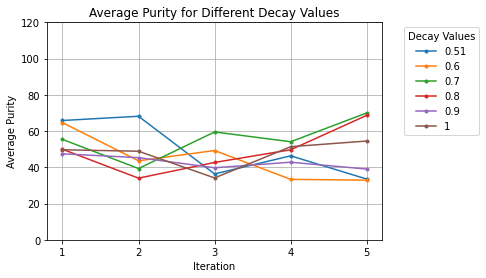

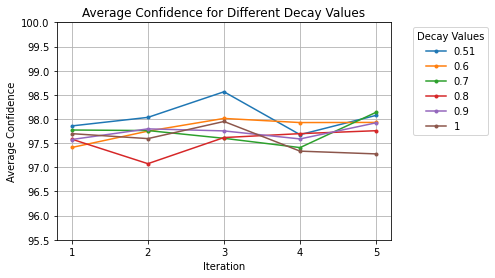

In [33]:
'''
Plotting purity and confidence for different values of decay
'''

mu_labels = ["0.51", "0.6", "0.7", "0.8", "0.9", "1"]
show_plot(range(1, 6), mu_avg_purities, 
          "Iteration", "Average Purity", 
          mu_labels, 
          xticks=range(1, 6), yaxisrange=[0, 120], 
          title="Average Purity for Different Decay Values", 
          legend_title="Decay Values", 
          saveAs="purity_mu.png")
show_plot(range(1, 6), mu_avg_conf, 
          "Iteration", "Average Confidence", 
          mu_labels, 
          xticks=range(1, 6), yaxisrange=[95.5, 100], 
          title="Average Confidence for Different Decay Values", 
          legend_title="Decay Values", 
          saveAs="confidence_mu.png")

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(k_lda_model, corpus, id2word)
pyLDAvis.save_html(vis, 'LDAvis_k.html')
vis

/home/jagaskak/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(mu_lda_model, corpus, id2word)
pyLDAvis.save_html(vis, 'LDAvis_mu.html')
vis

/home/jagaskak/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.006517  0.021173       1        1  16.102607
10     0.012749 -0.051225       2        1  15.629801
2     -0.022863  0.006162       3        1  14.873082
24     0.018050  0.006759       4        1   9.747932
4     -0.045616  0.034088       5        1   9.073386
19    -0.031704 -0.025510       6        1   8.421994
14     0.019646  0.030350       7        1   6.875721
20    -0.057496  0.025874       8        1   5.247657
1      0.027742  0.029918       9        1   1.987383
13    -0.002357  0.056310      10        1   1.329547
9     -0.017109 -0.013738      11        1   1.138137
28     0.044787  0.007253      12        1   1.128881
6      0.048306  0.079673      13        1   0.943807
5     -0.000764  0.122827      14        1   0.877130
21     0.025352  0.024601      15        1   0.840469
3     -0.016853 -0.039654      16        1   0.720508
25     0.009447 -0.030249      17        1   0.674213
12    -0.045801 -0.006612      18        1   0.606427
7     -0.018249  0.000589      19        1   0.531621
18     0.012433  0.036155      20        1   0.505066
29    -0.008705 -0.007965      21        1   0.454091
23     0.045977  0.015769      22        1   0.435424
16     0.017852 -0.007871      23        1   0.329157
8     -0.086996 -0.173545      24        1   0.300671
27     0.027970  0.025667      25        1   0.260502
11    -0.097951  0.055206      26        1   0.239686
17     0.063910  0.048173      27        1   0.210177
26     0.189217 -0.132560      28        1   0.185379
22     0.046033 -0.077069      29        1   0.183593
15    -0.163523 -0.060550      30        1   0.145949, topic_info=            Term         Freq        Total Category  logprob  loglift
10368  lieberman  2143.000000  2143.000000  Default  30.0000  30.0000
6753      string  2485.000000  2485.000000  Default  29.0000  29.0000
168         gore  3738.000000  3738.000000  Default  28.0000  28.0000
3597        else  2348.000000  2348.000000  Default  27.0000  27.0000
7           bush  2876.000000  2876.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
199          new     3.200894  1592.527189  Topic30  -6.1166   0.3200
112      clinton     3.233337  2337.640479  Topic30  -6.1066  -0.0537
330       budget     3.005408   619.354560  Topic30  -6.1797   1.2014
1068        york     3.035840  1075.907399  Topic30  -6.1696   0.6592
69         state     2.991309  1600.170659  Topic30  -6.1844   0.2475

[2692 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
10568     25  1.102435      abhor
18090      9  0.970030       ably
17736     11  1.024164    abolish
16988     14  0.969340  abolished
507        1  0.259022   abortion
...      ...       ...        ...
10405     30  0.047902     yorker
15933      2  0.993120    yorkers
15933     30  0.008636    yorkers
5900       4  0.991980   yorktown
13671     14  0.867570   zirinsky

[13110 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 11, 3, 25, 5, 20, 15, 21, 2, 14, 10, 29, 7, 6, 22, 4, 26, 13, 8, 19, 30, 24, 17, 9, 28, 12, 18, 27, 23, 16])